# Analyse de sensibilité globale par regression - application au cas de la déviation verticale de la poutre


## Déviation  verticale d'une poutre encastrée

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$

* $E$ : Young modulus (Pa)
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

| Variable |  Distribution |
|----------|---------------|
|E| Beta(alpha = 0.9, beta = 2.2, $a = 2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F = 3 \times 10^4$, $\sigma_F = 9\times 10^3$, shift = $15\times 10^3$)|
|L| Uniform(min=250.0, max= 260.0)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

## On the SRC function

The `ot.CorrelationAnalysis.SRC` function was a misnomer, as mentioned in the following issue:

https://github.com/openturns/openturns/issues/1753

Consider a linear model:
$$
Y = g(X) + \epsilon = \beta_0 + \sum_{i=1,2,\ldots,p} \beta_i X_i + \epsilon
$$
where $\beta_i$ are real parameters, for $i=1,2,\ldots,p$ and $\epsilon \sim \mathcal{N}\left(0, \sigma^2\right)$. 
Furthermore, we assume that the inputs $(X_1, ..., X_p)$ are independent. 
The importance factors of the linear model are : 
$$
\eta_i = \frac{\beta_i^2 \operatorname{Var}(X_i)}{\operatorname{Var}(Y)} \in [0,1]
$$
for $i=1,2,\ldots,p$.

The standardized regression coefficients are: 
$$
\textrm{SRC}_i = \frac{\beta_i \sqrt{\operatorname{Var}(X_i)}}{\sqrt{\operatorname{Var}(Y)}} \in \mathbb{R}
$$
for $i=1,2,\ldots,p$.

The importance factors are the squared SRC. 

In OpenTURNS v<=1.19,

- `ot.CorrelationAnalysis.SignedSRC` returns the SRC coefficients,
- `ot.CorrelationAnalysis.SRC` returns the importance factors. 

## Références

- https://github.com/openturns/openturns/pull/904
- http://openturns.github.io/openturns/latest/theory/data_analysis/pearson_coefficient.html

# Model definition

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np

In [2]:
ot.__version__

'1.24'

In [3]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

X = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F * L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (cm)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un méchanisme d'historique.

In [4]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [5]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (cm)"])

## Régression linéaire avec LinearLeastSquares

Nous allons utiliser la classe `LinearLeastSquares` pour créer la régression linéaire. Puis nous allons valider ce métamodèle avec `MetaModelValidation`. C'est une étape préparatoire essentielle pour valider la qualité du modèle linéaire. Puis nous allons estimer les facteurs d'importance. 

On commence par créer un plan d'expériences de type Monte-Carlo simple. 

In [6]:
n = 1000
sampleX = X.getSample(n)
sampleY = g(sampleX)

myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)

La méthode `run` permet d'estimer les coefficients du modèle. 

In [7]:
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[0.000367778] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.42462e-07,0.000412573,0.0981488,-0.0332083] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[-3.42462e-07,0.000412573,0.0981488,-0.0332083] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

La variable `responseSurface` est une instance de la classe `LinearEvaluation`, associée à une constante et une partie linéaire. 

In [8]:
val = ot.MetaModelValidation(sampleY, responseSurface(sampleX))

Puisque nous utilisons le même plan d'expériences pour l'apprentissage et la validation, nous obtenons le coefficient R2 (si nous avions utilisé un plan différent pour la validation, ce coefficient se nommerait Q2). 

In [9]:
r2 = val.computeR2Score()[0]
r2

0.9778846452464051

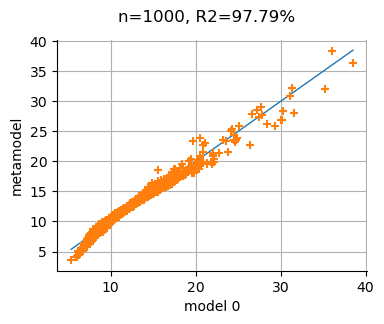

In [10]:
graph = val.drawValidation()
graph.setTitle("n=%d, R2=%.2f%%" % (n, r2 * 100))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que le modèle de régression linéaire est de bonne qualité, puisque le R2 est supérieur à 95%. 

On pourrait compléter l'analyse en utilisant un second plan pour la validation, mais il s'avère que cela n'est pas nécessaire dans notre cas particulier. 

Une hypothèse importance de la régression linéaire par moindres carrés est que la distribution des résidus doit être gaussienne. Pour le vérifier, nous résolvons le problème de moindres carrés avec `LinearLeastSquares` et calculons l'échantillon des résidus. 
Pour estimer $\sigma$, on considère le résidu :
$$
r_i = y_i - \tilde{g}(x_i)
$$
pour $i = 1, ..., n$. 
Nous estimons l'écart-type $\sigma$ du bruit grâce à l'estimateur non biaisé :
$$
\hat{\sigma} = \sqrt{\frac{1}{n - n_p} \sum_{j = 1}^n r_i^2}.
$$
où $n$ est la taille de l'échantillon, $n_p = 1 + p$ est le nombre de paramètres du modèle de régression linéaire, $y_i$ est la ième observation de la sortie et $\tilde{g}(x_i)$ est la prédiction par le modèle de régression linéaire. 


hat(sigma) = 0.6381


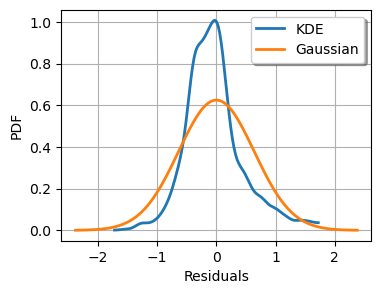

In [11]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
predicted_outputs = responseSurface(sampleX)
residuals_sample = sampleY - predicted_outputs
residuals_sample.setDescription(["Residuals"])
sample_size = sampleX.getSize()
input_dimension = sampleX.getDimension()
n_parameters = 1 + input_dimension
residuals_point = residuals_sample.asPoint()
sigma_hat = np.sqrt(residuals_point.normSquare() / (sample_size - n_parameters))
print("hat(sigma) = %.4f" % (sigma_hat))
noise_estimated = ot.Normal(0.0, sigma_hat)

graph = ot.KernelSmoothing().build(residuals_sample).drawPDF()
graph.setLegends(["KDE"])
curve = noise_estimated.drawPDF()
curve.setLegends(["Gaussian"])
graph.add(curve)
number_of_graphs = len(graph.getDrawables())
graph.setColors(ot.Drawable().BuildDefaultPalette(number_of_graphs))
graph.setLegendPosition("topright")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que la loi gaussienne est assez proche de la loi des résidus issue de l'estimation par lissage à noyau. L'écart entre les deux lois est probablement dû au fait que le modèle n'est pas exactement linéaire, sans en être toutefois très éloigné.

Puisque les hypothèses du modèle linéaire sont approximativement satisfaites, nous pouvons estimer les facteurs d'importance issus de la régression linéaire.

In [12]:
importance_factors = ot.CorrelationAnalysis(sampleX, sampleY).computeSquaredSRC()
importance_factors

class=Point name=Unnamed dimension=4 values=[0.138209,0.793874,0.00883377,0.0521553]

On observe que la somme des facteurs d'importance retournée par `computeSquaredSRC` n'est pas égale à 1. 

In [13]:
importance_factors.norm1()

0.9930722218508767

Cet écart est attendu car il est associé d'une part au fait que le modèle n'est pas parfaitement linéaire et d'autre part à l'erreur d'estimation des indices par la méthode d'échantillonnage.

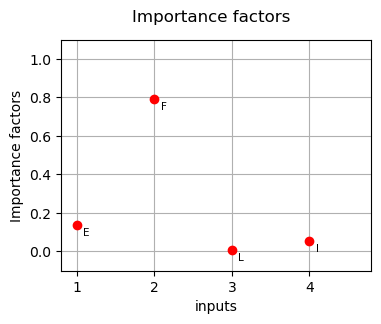

In [14]:
input_names = g.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    importance_factors, input_names, "Importance factors"
)
graph.setYTitle("Importance factors")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Nous pouvons comparer les résultats que nous avions obtenu par la méthode du développement de Taylor. 

| Méthode | E | F | L | I |
|---|---|---|---|---|
| Taylor | 0.1535 | 0.7856 | 0.0101 | 0.0508 |
| Regression | 0.1307 | 0.8117 | 0.0105 | 0.0470 |

On peut remarquer que, dans ce cas particulier, les deux méthodes donnent des résultats très similaires. En effet, 
- la méthode fondée sur le développement de Taylor fait l'hypothèse locale d'un comportement linéaire au voisinage du point moyen $E(X)$,
- la méthode fondée sur la regression linéaire fait l'hypothèse globale d'un comportement linéaire sur le domaine du vecteur aléatoire $X$.

Puisque, dans notre application, la combinaison particulière des lois marginales et de la fonction $g$ mènent à un comportement approximativement linéaire, les deux méthodes produisent des résultats similaires.

## Exercice 1 : analyse graphique sur le cas poutre

L'objectif de cet exercice est d'observer l'évolution de Y en fonction de chaque marginale $X_i$. 

- Pour `i=0,...,3`, utiliser la classe `Cloud` pour dessiner l'échantillon de points avec `sampleX[:,i]` en abscisse et `sampleY` en ordonnées.
- Observez le graphique. Quelle variable d'entrée $X_i$ semble avoir le plus d'impact sur la variabilité de la variable de sortie $Y$ ? Quelle variable d'entrée semble n'avoir aucun impact sur la variabilité de $Y$ ?

## Exercice 2 : le coefficient de corrélation de Pearson

En complément des indices SRC carrés, on utilise parfois les coefficients de corrélation de Pearson pour estimer la sensibilité :
$$
\operatorname{Corr}(Y,X_i) = \frac{\operatorname{Cov}(Y,X_i)}{\sqrt{\operatorname{Var}(Y)}\sqrt{\operatorname{Var}(X_i)}}
$$
pour $i=1,2,\ldots,p$.
En effet, ces coefficients permettent non seulement de quantifier la sensibilité, mais également d'obtenir le sens de variation de la sortie relativement à un changement dans chaque entrée. 
On utilise dans ce cas l'estimateur :
$$
\rho(Y,X_i) = \frac{\sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)\left(x^{(j)}_i-\bar{x}_i\right)}{\sqrt{\sum_{j=1}^n \left(y^{(j)}-\bar{y}\right)^2}\sqrt{\sum_{j=1}^n \left(x^{(j)}_i-\bar{x_i}\right)^2}}
$$
pour $i=1,2,\ldots,p$, où :
$$
\bar{x}_i = \frac{1}{n} \sum_{j=1}^n x^{(j)}_i.
$$
Pour hiérarchiser les variables d'entrée selon ce critère, c'est la valeur absolue du coefficient de Pearson dont on tient compte. 

L'objectif de cet exercice est de calculer les coefficients de corrélation linéaire de Pearson pour estimer la sensibilité de la sortie.
- Créer la variable `sampleXY` contenant un `Sample` de taille $n$ et de dimension 5. Remplir les 4 premières colonnes avec `sampleX` et la dernière colonne par `sampleY`.
- Utiliser la méthode `computePearsonCorrelation` pour estimer les coefficients de corrélation de Pearson. Quelle hiérarchisation se dégage de ce critère ?
- Calculer les carrés de ces coefficients ; qu'observez-vous ?
- Calculer la somme de ces carrés ; qu'observez-vous ?

## Exercice 3 : application à une fonction jouet

On considère la fonction $g$ définie par :
$$
g(X_1,X_2,X_3) = X_1 (X_2-X_1)+X_3
$$
pour tout $X_1,X_2,X_3\in\mathbb{R}$. 
Les trois variables d'entrée sont supposées indépendante et suivre les lois gaussiennes spécifiées dans le tableau suivant.

| Variable | Distribution |
|---|---|
| $X_1$ | Normale($\mu_1=0.1$,$\sigma_1 = 1$) |
| $X_2$ | Normale($\mu_2=1$,$\sigma_2 = 2$) |
| $X_3$ | Normale($\mu_3=2$,$\sigma_3 = 0.2$) |

*Questions*
- Pour cette fonction, calculer les coefficients d'un modèle de régression linéaire au sens des moindres carrés.
- Ce modèle de régression est-il de bonne qualité ?
- Quels sont les indices SRC carrés de ce modèle ?

## Exercice 4 : modèle de poutre avec distributions élargies

On considère le cas de la déviation verticale de la poutre encastrée, dans lequel on modifie les paramètres des distributions marginales de $E$ et $F$. Les paramètres modifiés sont présentés dans la table ci-dessous.

|Variable|  Distribution|
| ------------- |-------------|
|E| Beta(alpha = 0.9, beta = 2.2, a = $1.0\times 10^7$, $b = 10.0\times 10^7$) |
|F| Lognormal($\mu_F=3 \times 10^4$, $\sigma_F=20\times 10^3$, shift=$15\times 10^3$)|
|L| Uniform(min=250.0, max= 260.0)|
|I| Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)|

- Calculer les paramètres du modèle de régression linéaire pour ce nouveau modèle. 
- Calculer le coefficient de prédictivité $R^2$. Comment a-t-il évolué par rapport à la situation précédente ? Pourquoi ? Que conclure ?

## Exercice 5 : Intervalle de confiance des indices SRC carrés

On considère le modèle de poutre initial. Déterminer un intervalle de confiance à 95% des indices SRC carrés.

Pour cela, on peut procéder par bootstrap. Pour générer deux échantillons bootstrap cohérents, on pourra utiliser le code suivant :

```
indices = ot.BootstrapExperiment.GenerateSelection(sample_size, sample_size)
sampleX_bootstrap, sampleY_bootstrap = sampleX[indices], sampleY[indices]
```

## Exercice 6 : Validation du modèle de régression linéaire

Un statisticien scrupuleux se pose des questions sur la validation du modèle de régression linéaire. Premièrement, il indique que le coefficient $R^2$ peut être trompeur, car le plan d'expériences d'apprentissage a été utilisé. Dans ce cas, il peut arriver que le $R^2$ puisse être plus favorable qu'on ne s'y attend. Une alternative consisterait à évaluer le coefficient $R^2$ corrigé. Deuxièmement, il indique que la validation graphique de la distribution des résidus est discutable. En effet, la comparaison entre la densité de probabilité gaussienne et la densité de probabilité de la distribution des résidus estimée par lissage à noyau est plutôt qualitative. Pour répondre à ces interrogations, nous proposons les questions suivantes.

**Questions**

- Générer un échantillon de validation indépendant de l'échantillon d'apprentissage. Utiliser une taille égale à 1000 pour l'échantillon de validation. Utiliser la classe `MetamodelValidation` et estimer le coefficient $Q^2$. Que peut-on conclure ?
- Utiliser la fonction `DrawQQplot()` et dessiner le QQ-plot permettant de vérifier que la distribution des résidus est gaussienne.